In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

# Training
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-12-11 23:23:12.822584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 23:23:12.872733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:23:13.497553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:23:14.183174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cu

In [3]:
Data = pd.read_csv("Life Expectancy Data Cleaned With Insurance.csv")
Data = Data.drop(["Unnamed: 0"], axis=1)
# print(Data.columns)
# print(np.unique(Data["Country"]))

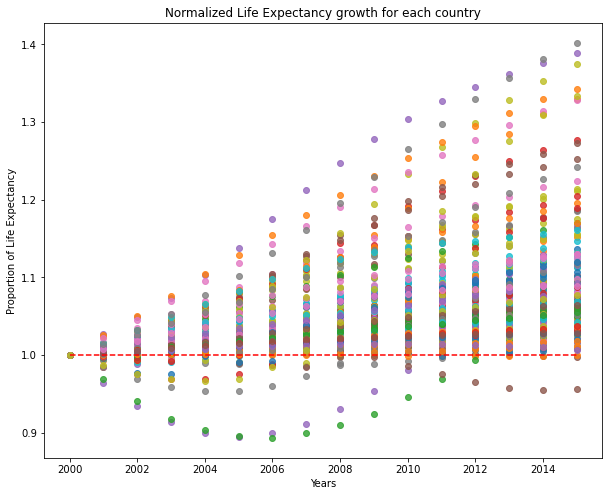

In [4]:
countries = np.unique(Data["Country"])

fig = plt.figure(figsize=(10,8))

for cont in countries:
    life_exp = Data[Data["Country"]==cont]["Life_expectancy"].values
    years = Data[Data["Country"]==cont]["Year"].values
    year2000ind = np.where(years == min(years))  # for the purpose of separate cases where life exp is between 50-60, 60-70, 70-80, and so on.
    life_exp_2000 = life_exp[year2000ind][0]
    plt.scatter(years,life_exp/life_exp_2000, label=cont, alpha=0.8)
plt.plot(np.arange(2000,2016,1),np.ones(16),"--r")
plt.title("Normalized Life Expectancy growth for each country")
plt.ylabel("Proportion of Life Expectancy")
plt.xlabel("Years")
plt.show()

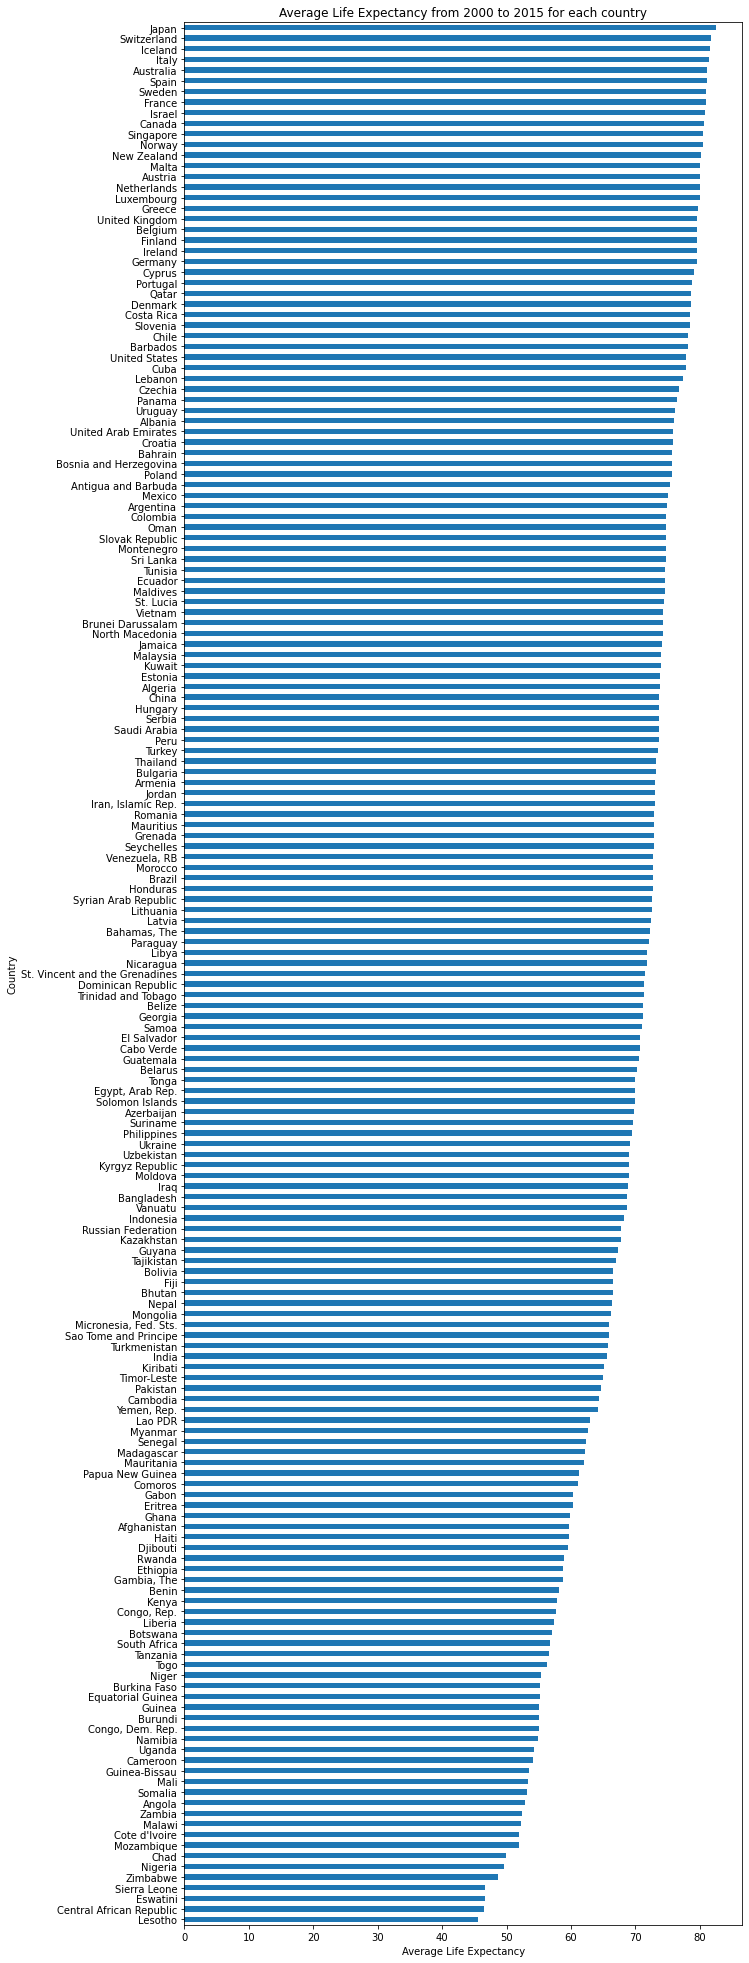

In [5]:
Data.groupby("Country")["Life_expectancy"].mean().sort_values().plot(kind="barh", 
                                                                      title="Average Life Expectancy from 2000 to 2015 for each country", 
                                                                      xlabel="Average Life Expectancy",
                                                                      figsize=(10,35))
plt.show()

# ***Correlation Analysis***

**Title:** *Life Expectancy vs GDP*

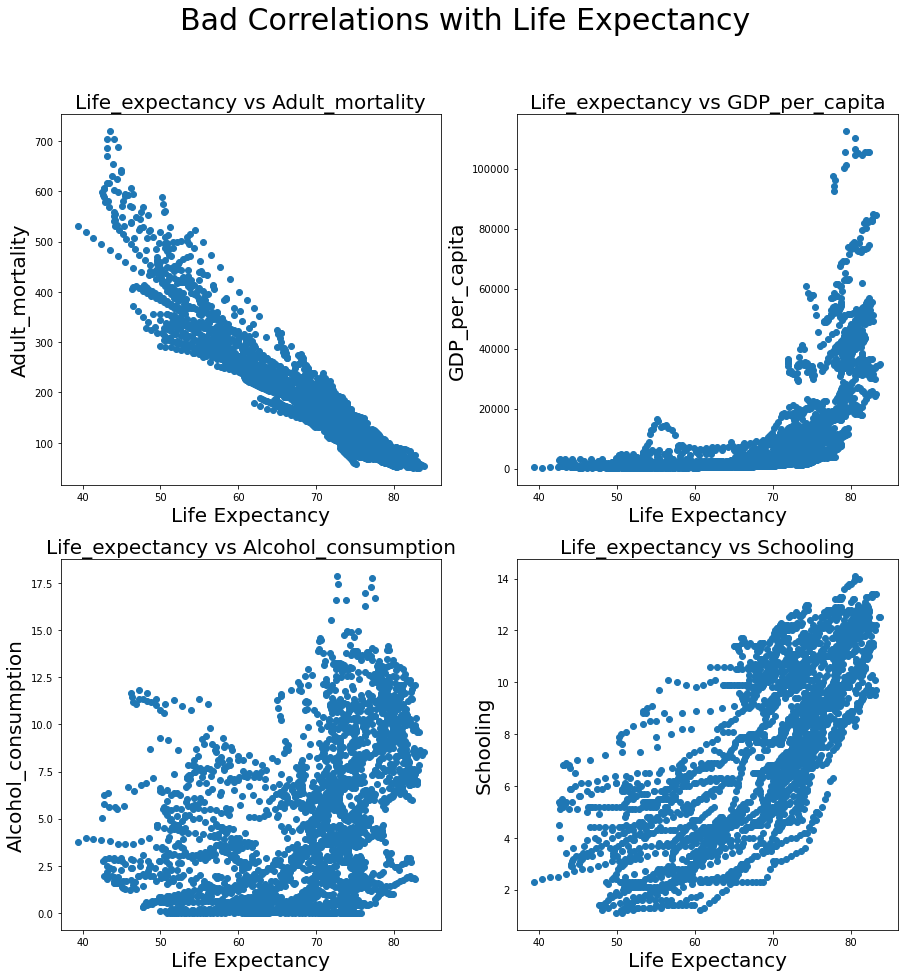

In [6]:
good = ["Adult_mortality","GDP_per_capita","Alcohol_consumption","Schooling"]
# good = ["Population_mln", "Thinness_ten_nineteen_years", "Hepatitis_B","Alcohol_consumption"]

# for ind, col in enumerate(Data.columns.values[3:]):
#     pd.plotting.scatter_matrix(Data[['Life_expectancy', col]],figsize=(10,8),alpha=0.5,marker="o")
# plt.show()

f, axarr = plt.subplots(2, 2)
f.suptitle("Bad Correlations with Life Expectancy",fontsize=30)
axarr[0, 0].scatter(Data["Life_expectancy"], Data[good[0]])
axarr[0, 0].set_title('Life_expectancy vs '+ good[0], fontsize=20)
axarr[0, 0].set_xlabel("Life Expectancy", fontsize=20)
axarr[0, 0].set_ylabel(good[0], fontsize=20)

axarr[0, 1].scatter(Data["Life_expectancy"], Data[good[1]])
axarr[0, 1].set_title('Life_expectancy vs '+ good[1], fontsize=20)
axarr[0, 1].set_xlabel("Life Expectancy", fontsize=20)
axarr[0, 1].set_ylabel(good[1], fontsize=20)

axarr[1, 0].scatter(Data["Life_expectancy"], Data[good[2]])
axarr[1, 0].set_title('Life_expectancy vs '+ good[2], fontsize=20)
axarr[1, 0].set_xlabel("Life Expectancy", fontsize=20)
axarr[1, 0].set_ylabel(good[2], fontsize=20)

axarr[1, 1].scatter(Data["Life_expectancy"], Data[good[3]])
axarr[1, 1].set_title('Life_expectancy vs '+ good[3], fontsize=20)
axarr[1, 1].set_xlabel("Life Expectancy", fontsize=20)
axarr[1, 1].set_ylabel(good[3], fontsize=20)

f.set_figheight(15)
f.set_figwidth(15)
plt.savefig("sub_Cor_diverse.jpg")
plt.show()



# *Overall Correlationship between 'Life Expectancy' and others*

In [7]:
# overall = Data.drop(["Country","Region"], axis=1).corr()["Life_expectancy"]
overall = Data.drop(["Country","Region"], axis=1).corr()["Universal_insurance"]
print(overall)
overall_v = np.array(overall.values)
overall_vals = np.array(abs(overall.values))
overall_keys = np.array(overall.keys())
temp_sort = np.sort(overall_vals)

top_5_keys = [overall_keys[np.where(overall_vals==ind)[0][0]] for ind in temp_sort[-6:-1]]
top_5_vals = overall[top_5_keys]
print("\n", "Top 5 features and scores according to correlation")
# print(top_5_keys[::-1])
print(top_5_vals[::-1])

Year                           0.010511
Infant_deaths                 -0.433673
Under_five_deaths             -0.403798
Adult_mortality               -0.427256
Alcohol_consumption            0.299091
Hepatitis_B                    0.212651
Measles                        0.233822
BMI                            0.142452
Polio                          0.355988
Diphtheria                     0.361636
Incidents_HIV                 -0.117711
GDP_per_capita                 0.477458
Population_mln                 0.169343
Thinness_ten_nineteen_years   -0.114337
Thinness_five_nine_years      -0.093425
Schooling                      0.375178
Economy_status_Developed       0.408762
Economy_status_Developing     -0.408762
Life_expectancy                0.479867
Universal_insurance            1.000000
Name: Universal_insurance, dtype: float64

 Top 5 features and scores according to correlation
Life_expectancy             0.479867
GDP_per_capita              0.477458
Infant_deaths              -0.4

# ***Advance Cleaning and checking details***

In [8]:
Data = Data.replace(True,1)
Data = Data.replace(False,0)

**$R^2$ Analysis**

In [9]:
# setting
max_comb = []
max_Rsqured = 0
independent_vars = Data.drop(["Life_expectancy","Year","Country","Region"], axis=1).columns.values
# get the all combinations of independent variables
combs = []
for i in range(1,6):
    for el in combinations(independent_vars,i):
        combs.append(list(el))
y = Data["Life_expectancy"].values
# find the max R squared
for combination in combs:
    X_temp = Data[combination]
    X = sm.add_constant(X_temp).values
    
    model = sm.OLS(y,X).fit()
    Rsquared = model.rsquared
    if max_Rsqured < Rsquared:
        max_Rsqured = Rsquared
        max_comb = combination
        print(max_Rsqured)
        print(max_comb)

0.8464587328014879
['Infant_deaths']
0.8471713815710928
['Under_five_deaths']
0.8937062183385016
['Adult_mortality']
0.9710178160801382
['Infant_deaths', 'Adult_mortality']
0.9712419197053223
['Infant_deaths', 'Under_five_deaths', 'Adult_mortality']
0.9741463365859641
['Infant_deaths', 'Adult_mortality', 'Alcohol_consumption']
0.9748141525464107
['Infant_deaths', 'Adult_mortality', 'GDP_per_capita']
0.9751386519439105
['Infant_deaths', 'Adult_mortality', 'Economy_status_Developed']
0.9753895308321467
['Under_five_deaths', 'Adult_mortality', 'Economy_status_Developed']
0.9759954746864116
['Infant_deaths', 'Under_five_deaths', 'Adult_mortality', 'GDP_per_capita']
0.9764658493732222
['Infant_deaths', 'Under_five_deaths', 'Adult_mortality', 'Economy_status_Developed']
0.977240220032149
['Under_five_deaths', 'Adult_mortality', 'Alcohol_consumption', 'GDP_per_capita']
0.9778393387694932
['Infant_deaths', 'Under_five_deaths', 'Adult_mortality', 'Alcohol_consumption', 'GDP_per_capita']
0.97784

In [10]:
cols = list(Data.columns)
print(Data.dtypes)

Country                         object
Region                          object
Year                             int64
Infant_deaths                  float64
Under_five_deaths              float64
Adult_mortality                float64
Alcohol_consumption            float64
Hepatitis_B                      int64
Measles                          int64
BMI                            float64
Polio                            int64
Diphtheria                       int64
Incidents_HIV                  float64
GDP_per_capita                   int64
Population_mln                 float64
Thinness_ten_nineteen_years    float64
Thinness_five_nine_years       float64
Schooling                      float64
Economy_status_Developed         int64
Economy_status_Developing        int64
Life_expectancy                float64
Universal_insurance              int64
dtype: object


In [11]:
temp = Data.drop(["Country","Region"], axis=1)
cols = list(temp.columns)

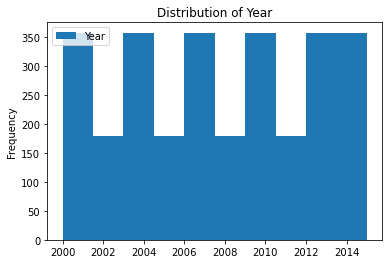

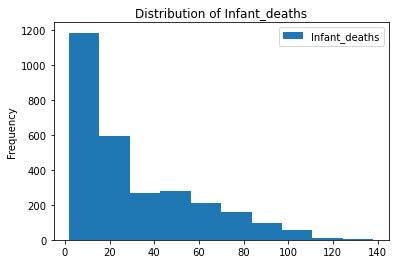

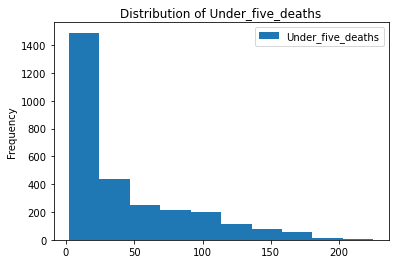

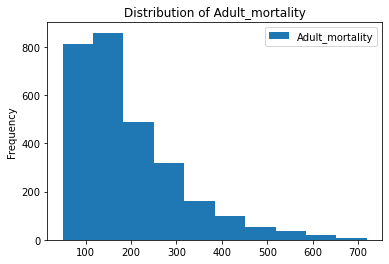

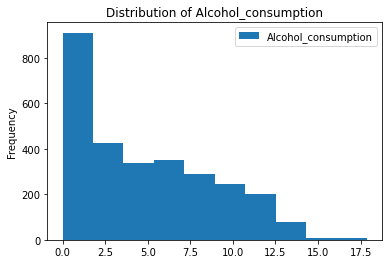

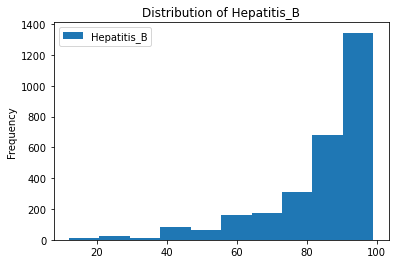

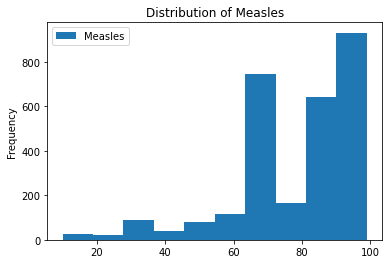

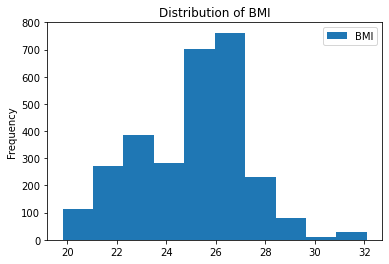

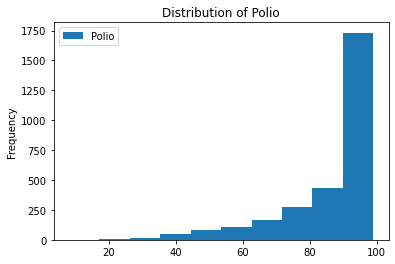

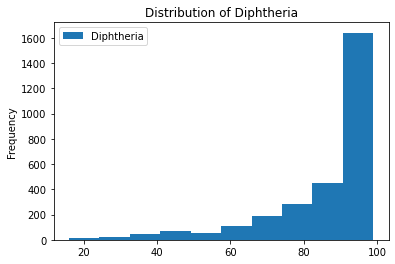

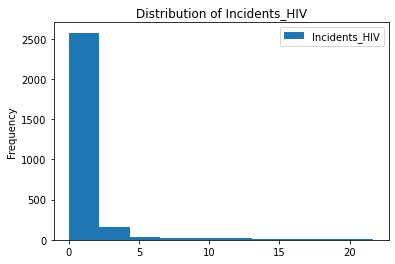

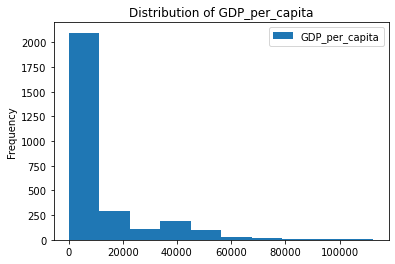

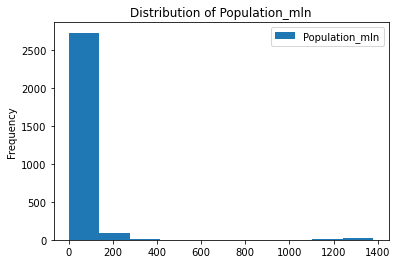

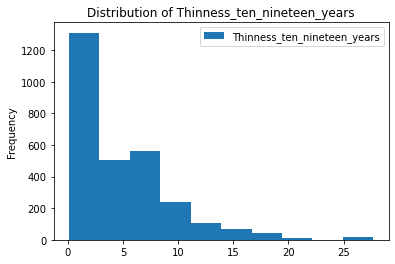

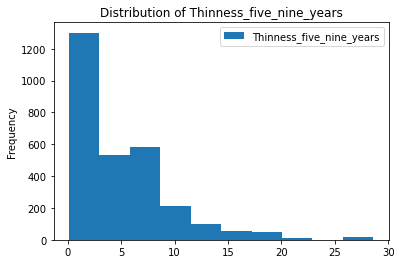

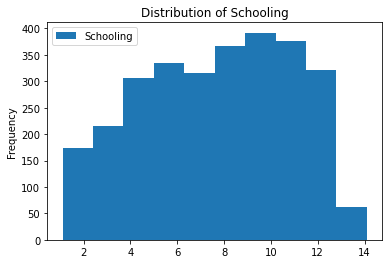

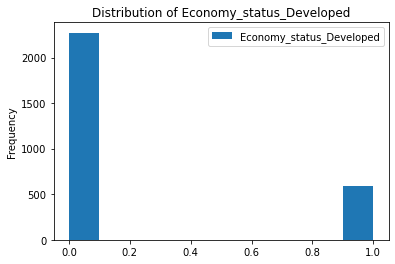

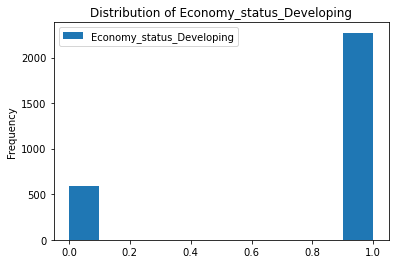

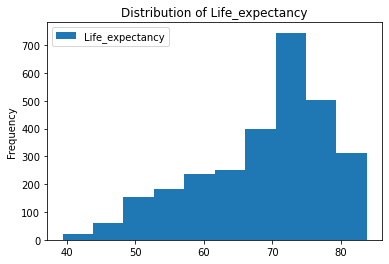

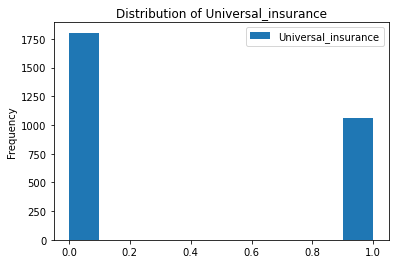

In [12]:
for col in cols:
    temp.plot(kind='hist',y=col)
    plt.title(f"Distribution of {col}")
    plt.show()

In [13]:
mask1 = Data["Universal_insurance"] == True
mask2 = Data["Universal_insurance"] == False
uni_info = Data[mask1]
other_info = Data[mask2]

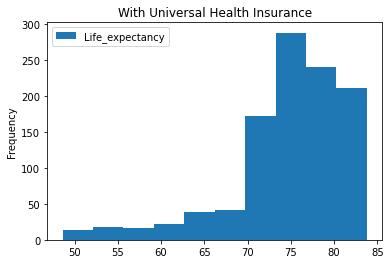

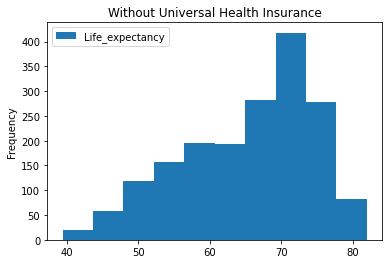

In [15]:
uni_info.plot(kind="hist", y=["Life_expectancy"])
plt.title("With Universal Health Insurance")
plt.show()

other_info.plot(kind="hist", y=["Life_expectancy"])
plt.title("Without Universal Health Insurance")
plt.show()
